In [41]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

DrawingOptions.bondLineWidth=1.8

from openforcefield.topology import Molecule
from offPELE.utils import get_data_file_path

In [46]:
file_path = get_data_file_path('ligands/BNZ.pdb')
ligand_rdkit_molecule = Chem.rdmolfiles.MolFromPDBFile(file_path, removeHs=False)
ligand_molecule = Molecule.from_rdkit(ligand_rdkit_molecule)

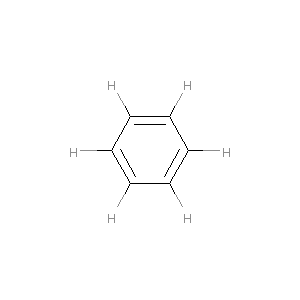

In [47]:
ligand_rdkit_molecule.Compute2DCoords()
Chem.Draw.MolToImage(ligand_rdkit_molecule)

In [48]:
from openforcefield.typing.engines.smirnoff import ForceField
#from openforcefields import get_forcefield_dirs_paths
forcefield = ForceField('openff-1.1.1.offxml')

In [49]:
system = forcefield.create_openmm_system(ligand_molecule.to_topology())

In [6]:
forces = system.getForces()

In [19]:
force = forces[1]

In [21]:
force.getTorsionParameters(1)

[1,
 3,
 6,
 0,
 2,
 Quantity(value=3.141592653589793, unit=radian),
 Quantity(value=1.5341333333333336, unit=kilojoule/mole)]

In [23]:
from simtk.openmm import XmlSerializer
with open('complex.xml', 'w') as f:
    f.write(XmlSerializer.serialize(system))

## Get atomic mass

In [50]:
for atom in ligand_molecule.to_topology().topology_particles:
    print(atom)
    

TopologyAtom 0 with reference atom <Atom name='C1' atomic number='6'> and parent TopologyMolecule <openforcefield.topology.topology.TopologyMolecule object at 0x7fecbf485650>
TopologyAtom 1 with reference atom <Atom name='C2' atomic number='6'> and parent TopologyMolecule <openforcefield.topology.topology.TopologyMolecule object at 0x7fecbf485650>
TopologyAtom 2 with reference atom <Atom name='C3' atomic number='6'> and parent TopologyMolecule <openforcefield.topology.topology.TopologyMolecule object at 0x7fecbf485650>
TopologyAtom 3 with reference atom <Atom name='C4' atomic number='6'> and parent TopologyMolecule <openforcefield.topology.topology.TopologyMolecule object at 0x7fecbf485650>
TopologyAtom 4 with reference atom <Atom name='C5' atomic number='6'> and parent TopologyMolecule <openforcefield.topology.topology.TopologyMolecule object at 0x7fecbf485650>
TopologyAtom 5 with reference atom <Atom name='C6' atomic number='6'> and parent TopologyMolecule <openforcefield.topology.to

## Forcefield parameter handlers

### Parameter handler dependencies

In [58]:
for tagname, handler in forcefield._parameter_handlers.items():
    print('{}:'.format(tagname))
    if handler._DEPENDENCIES is not None:
        for dep in handler._DEPENDENCIES:
            print(' -', dep._TAGNAME)

Constraints:
Bonds:
  - Constraints
Angles:
  - Constraints
ProperTorsions:
ImproperTorsions:
vdW:
Electrostatics:
  - vdW
LibraryCharges:
  - vdW
  - Electrostatics
ToolkitAM1BCC:
  - vdW
  - Electrostatics
  - LibraryCharges


In [59]:
ordered_parameter_handlers = forcefield._resolve_parameter_handler_order()

In [63]:
for handler in ordered_parameter_handlers:
    print(handler._TAGNAME)

vdW
Electrostatics
LibraryCharges
ToolkitAM1BCC
ImproperTorsions
ProperTorsions
Constraints
Angles
Bonds


In [154]:
ligand_topology = ligand_molecule.to_topology()

### Extract vdW parameters

In [155]:
from openforcefield.typing.engines.smirnoff.parameters import vdWHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, vdWHandler):
        break

vdW_handler = handler
print(vdW_handler._TAGNAME)

vdW


In [156]:
vdW_matches = vdW_handler.find_matches(ligand_topology)

In [157]:
for topology_atom_indices, vdW_match in vdW_matches.items():
    print(topology_atom_indices, vdW_match.parameter_type.epsilon, vdW_match.parameter_type.sigma,
          vdW_match.parameter_type.rmin_half)

(0,) 0.086 kcal/mol None 1.908 A
(1,) 0.086 kcal/mol None 1.908 A
(2,) 0.086 kcal/mol None 1.908 A
(3,) 0.086 kcal/mol None 1.908 A
(4,) 0.086 kcal/mol None 1.908 A
(5,) 0.086 kcal/mol None 1.908 A
(6,) 0.015 kcal/mol None 1.459 A
(7,) 0.015 kcal/mol None 1.459 A
(8,) 0.015 kcal/mol None 1.459 A
(9,) 0.015 kcal/mol None 1.459 A
(10,) 0.015 kcal/mol None 1.459 A
(11,) 0.015 kcal/mol None 1.459 A


### Extract electrostatic parameters

In [183]:
from openforcefield.typing.engines.smirnoff.parameters import ElectrostaticsHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, ElectrostaticsHandler):
        break

electrostatics_handler = handler
print(electrostatics_handler._TAGNAME)

Electrostatics


In [184]:
electrostatics_matches = electrostatics_handler.find_matches(ligand_topology)

In [185]:
for topology_atom_indices, electrostatics_match in electrostatics_matches.items():
    print(topology_atom_indices, electrostatics_match.parameter_type.epsilon, electrostatics_match.parameter_type.sigma,
          electrostatics_match.parameter_type.rmin_half)

### Extract library charge parameters

In [186]:
from openforcefield.typing.engines.smirnoff.parameters import LibraryChargeHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, LibraryChargeHandler):
        break

library_charge_handler = handler
print(library_charge_handler._TAGNAME)

LibraryCharges


In [187]:
library_charge_matches = library_charge_handler.find_matches(ligand_topology)

In [188]:
for topology_atom_indices, library_charge_match in library_charge_matches.items():
    print(topology_atom_indices, library_charge_match.parameter_type.epsilon, library_charge_match.parameter_type.sigma,
          library_charge_match.parameter_type.rmin_half)

### Extract ToolkitAM1BCC parameters

In [189]:
from openforcefield.typing.engines.smirnoff.parameters import ToolkitAM1BCCHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, ToolkitAM1BCCHandler):
        break

toolkit_AM1BCC_handler = handler
print(toolkit_AM1BCC_handler._TAGNAME)

ToolkitAM1BCC


In [190]:
toolkit_AM1BCC_matches = toolkit_AM1BCC_handler.find_matches(ligand_topology)

In [191]:
for topology_atom_indices, toolkit_AM1BCC_match in toolkit_AM1BCC_matches.items():
    print(topology_atom_indices, library_charge_match.parameter_type.epsilon, library_charge_match.parameter_type.sigma,
          library_charge_match.parameter_type.rmin_half)

In [192]:
toolkit_AM1BCC_match.

SyntaxError: invalid syntax (<ipython-input-192-61b93e4afa3f>, line 1)

In [169]:
ligand_topology

In [177]:
for molecule in ligand_topology.reference_molecules:
    print(molecule)

Molecule with name 'HYDROLASE' and SMILES '[H][c]1[c]([H])[c]([H])[c]([H])[c]([H])[c]1[H]'


In [180]:
molecule.compute_partial_charges_am1bcc()

In [182]:
molecule.compute_partial_charges()

NotImplementedError: 

In [181]:
molecule.partial_charges

Quantity(value=array([-0.13, -0.13, -0.13, -0.13, -0.13, -0.13,  0.13,  0.13,  0.13,
        0.13,  0.13,  0.13]), unit=elementary charge)

### Extract bond parameters

In [90]:
from openforcefield.typing.engines.smirnoff.parameters import BondHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, BondHandler):
        break

bond_handler = handler
print(bond_handler._TAGNAME)

Bonds


In [91]:
bond_matches = bond_handler.find_matches(ligand_topology)

In [92]:
for topology_atom_indices, bond_match in bond_matches.items():
    print(topology_atom_indices, bond_match.parameter_type.length, bond_match.parameter_type.k)

(0, 1) 1.388684811982 A 703.7861640732 kcal/(A**2 mol)
(0, 5) 1.388684811982 A 703.7861640732 kcal/(A**2 mol)
(0, 6) 1.085028902395 A 808.0585583296 kcal/(A**2 mol)
(1, 2) 1.388684811982 A 703.7861640732 kcal/(A**2 mol)
(1, 7) 1.085028902395 A 808.0585583296 kcal/(A**2 mol)
(2, 3) 1.388684811982 A 703.7861640732 kcal/(A**2 mol)
(2, 8) 1.085028902395 A 808.0585583296 kcal/(A**2 mol)
(3, 4) 1.388684811982 A 703.7861640732 kcal/(A**2 mol)
(3, 9) 1.085028902395 A 808.0585583296 kcal/(A**2 mol)
(4, 5) 1.388684811982 A 703.7861640732 kcal/(A**2 mol)
(4, 10) 1.085028902395 A 808.0585583296 kcal/(A**2 mol)
(5, 11) 1.085028902395 A 808.0585583296 kcal/(A**2 mol)


### Extract angle parameters

In [93]:
from openforcefield.typing.engines.smirnoff.parameters import AngleHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, AngleHandler):
        break

angle_handler = handler
print(angle_handler._TAGNAME)

Angles


In [98]:
angle_matches = angle_handler.find_matches(ligand_topology)

In [100]:
for topology_atom_indices, angle_match in angle_matches.items():
    print(topology_atom_indices, angle_match.parameter_type.angle, angle_match.parameter_type.k)

(0, 1, 2) 132.0554838002 deg 153.7825131248 kcal/(mol rad**2)
(0, 1, 7) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(0, 5, 4) 132.0554838002 deg 153.7825131248 kcal/(mol rad**2)
(0, 5, 11) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(1, 0, 5) 132.0554838002 deg 153.7825131248 kcal/(mol rad**2)
(1, 0, 6) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(1, 2, 3) 132.0554838002 deg 153.7825131248 kcal/(mol rad**2)
(1, 2, 8) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(2, 1, 7) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(2, 3, 4) 132.0554838002 deg 153.7825131248 kcal/(mol rad**2)
(2, 3, 9) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(3, 2, 8) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(3, 4, 5) 132.0554838002 deg 153.7825131248 kcal/(mol rad**2)
(3, 4, 10) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(4, 3, 9) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(4, 5, 11) 137.9694119749 deg 66.76856405714 kcal/(mol rad**2)
(5, 0

### Extract proper torsion parameters

In [104]:
from openforcefield.typing.engines.smirnoff.parameters import ProperTorsionHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, ProperTorsionHandler):
        break

proper_torsion_handler = handler
print(proper_torsion_handler._TAGNAME)

ProperTorsions


In [105]:
proper_torsion_matches = proper_torsion_handler.find_matches(ligand_topology)

In [110]:
for topology_atom_indices, proper_torsion_match in proper_torsion_matches.items():
    print(topology_atom_indices, proper_torsion_match.parameter_type.periodicity,
          proper_torsion_match.parameter_type.phase, proper_torsion_match.parameter_type.k)

(0, 1, 2, 3) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(0, 1, 2, 8) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(0, 5, 4, 3) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(0, 5, 4, 10) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(1, 0, 5, 4) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(1, 0, 5, 11) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(1, 2, 3, 4) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(1, 2, 3, 9) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(2, 1, 0, 5) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=2.639861699998, unit=kilocalorie/mole)]
(2, 1, 0

### Extract improper torsion parameters

In [111]:
from openforcefield.typing.engines.smirnoff.parameters import ImproperTorsionHandler

for handler in ordered_parameter_handlers:
    if isinstance(handler, ImproperTorsionHandler):
        break

improper_torsion_handler = handler
print(improper_torsion_handler._TAGNAME)

ImproperTorsions


In [112]:
improper_torsion_matches = improper_torsion_handler.find_matches(ligand_topology)

In [113]:
for topology_atom_indices, improper_torsion_match in improper_torsion_matches.items():
    print(topology_atom_indices, improper_torsion_match.parameter_type.periodicity,
          improper_torsion_match.parameter_type.phase, improper_torsion_match.parameter_type.k)

(0, 1, 2, 7) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=1.1, unit=kilocalorie/mole)]
(0, 5, 4, 11) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=1.1, unit=kilocalorie/mole)]
(1, 0, 5, 6) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=1.1, unit=kilocalorie/mole)]
(1, 2, 3, 8) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=1.1, unit=kilocalorie/mole)]
(2, 3, 4, 9) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=1.1, unit=kilocalorie/mole)]
(3, 4, 5, 10) [2] [Quantity(value=180.0, unit=degree)] [Quantity(value=1.1, unit=kilocalorie/mole)]
